In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet transformers datasets peft
!pip install --quiet tensorboard
!pip install --quiet evaluate
!pip install --quiet -U datasets
!pip install --quiet rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import shutil
import torch
import numpy as np
import pandas as pd

# Model Loading
from transformers import ProphetNetTokenizer, ProphetNetForConditionalGeneration
from peft import LoraConfig, get_peft_model

# Dataset Loading
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq, AutoTokenizer
from datasets import load_dataset
import evaluate

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA L4


# Data Loading

In [5]:
# Now load normally
raw_datasets = load_dataset("xsum",  trust_remote_code = True)
print(raw_datasets)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})


In [6]:
for example in raw_datasets["train"].select(range(2)):
    print("=== Article ===\n", example["document"], "\n")
    print("=== Reference Summary ===\n", example["summary"], "\n")

=== Article ===
 The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate th

In [7]:
tokenizer = ProphetNetTokenizer.from_pretrained("microsoft/prophetnet-large-uncased-cnndm")

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

prophetnet.tokenizer:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

In [8]:
train_dataset = raw_datasets["train"]
val_dataset = raw_datasets["validation"]

In [9]:
max_input_length = 512
max_target_length = 64

def preprocess_function(examples):
    inputs = examples["document"]
    targets = examples["summary"]
    model_inputs = tokenizer(inputs, max_length = max_input_length, truncation = True, padding = "max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length = max_target_length, truncation = True, padding = "max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [10]:
tokenized_train = train_dataset.map(preprocess_function, batched = True, remove_columns = train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched = True, remove_columns = val_dataset.column_names)

Map:   0%|          | 0/204045 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/11332 [00:00<?, ? examples/s]

# Model Loading & LoRA

In [18]:
tokenizer = ProphetNetTokenizer.from_pretrained("microsoft/prophetnet-large-uncased-cnndm")
base_model = ProphetNetForConditionalGeneration.from_pretrained("microsoft/prophetnet-large-uncased-cnndm")

In [19]:
base_model

ProphetNetForConditionalGeneration(
  (prophetnet): ProphetNetModel(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (encoder): ProphetNetEncoder(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): ProphetNetPositionalEmbeddings(512, 1024, padding_idx=0)
      (embeddings_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x ProphetNetEncoderLayer(
          (self_attn): ProphetNetAttention(
            (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (feed_forward): ProphetNetFeedForward(
            (a

In [20]:
# Configure LoRA to adapt both attention and FFN layers (r=16)
lora_config = LoraConfig(
    r = 16,
    lora_alpha = 16,
    target_modules = [
        "query_proj", "key_proj", "value_proj", "out_proj", # Attention projections
        "intermediate", "output" # FFN layers
    ],
    lora_dropout = 0.1,
    bias = "none",
    task_type = "SEQ_2_SEQ_LM"
)

In [21]:
model = get_peft_model(base_model, lora_config)

In [22]:
model

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): ProphetNetForConditionalGeneration(
      (prophetnet): ProphetNetModel(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0)
        (encoder): ProphetNetEncoder(
          (word_embeddings): Embedding(30522, 1024, padding_idx=0)
          (position_embeddings): ProphetNetPositionalEmbeddings(512, 1024, padding_idx=0)
          (embeddings_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-11): 12 x ProphetNetEncoderLayer(
              (self_attn): ProphetNetAttention(
                (key_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False)
     

In [23]:
# Trainable parameter percentage
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable:,} / {total:,} ({100 * trainable / total:.2f}%)")

Trainable parameters: 8,650,752 / 399,972,352 (2.16%)


In [24]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [25]:
training_args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/prophetnet_xsum_lora_both",  # Output directory
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    gradient_accumulation_steps = 8,
    eval_strategy = "steps",
    eval_steps = 1000,
    save_strategy = "steps",
    save_steps = 1000,
    logging_strategy = "steps",
    logging_steps = 50,
    save_total_limit = 2, # Keeps only the last 2 checkpoints
    learning_rate = 4e-5,
    num_train_epochs = 3,
    warmup_steps = 500,
    weight_decay = 0.01,
    fp16 = True, # Enable mixed precision
    load_best_model_at_end = True,
    metric_for_best_model = "loss",
    greater_is_better = False
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    tokenizer = tokenizer,
    data_collator = data_collator
)

In [23]:
trainer.train(resume_from_checkpoint = "/content/drive/MyDrive/prophetnet_xsum_lora_both/checkpoint-5000")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neel-1999 (neel-1999-humber-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
6000,4.623200,4.533448
7000,4.608500,4.531530
8000,4.616300,4.528912
9000,4.602600,4.527869


TrainOutput(global_step=9564, training_loss=2.199675697604267, metrics={'train_runtime': 21437.193, 'train_samples_per_second': 28.555, 'train_steps_per_second': 0.446, 'total_flos': 6.913033761718272e+17, 'train_loss': 2.199675697604267, 'epoch': 2.9999215870775506})

# Saving the Model

In [24]:
# Saving Log Model & Tokenizer
best_model_path = "./prophetnet_xsum_lora_both/checkpoint-best"
save_path = "/content/drive/MyDrive/prophetnet_xsum_lora_best"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/prophetnet_xsum_lora_best/tokenizer_config.json',
 '/content/drive/MyDrive/prophetnet_xsum_lora_best/special_tokens_map.json',
 '/content/drive/MyDrive/prophetnet_xsum_lora_best/prophetnet.tokenizer',
 '/content/drive/MyDrive/prophetnet_xsum_lora_best/added_tokens.json')

In [25]:
# Saving Log History
logs_df = pd.DataFrame(trainer.state.log_history)

csv_path = "/content/drive/MyDrive/prophetnet_training_logs.csv"

logs_df.to_csv(csv_path, index = False)

In [26]:
import shutil

src_dir = training_args.logging_dir
dst_dir = "/content/drive/MyDrive/prophetnet_tb_logs"

if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)
shutil.copytree(src_dir, dst_dir)

print(f"TensorBoard logs copied to {dst_dir}")

TensorBoard logs copied to /content/drive/MyDrive/prophetnet_tb_logs


# Model Evaluation

In [10]:
import random
import matplotlib.pyplot as plt
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [11]:
test_dataset = raw_datasets["test"]
tokenized_test = test_dataset.map(preprocess_function, batched = True, remove_columns = test_dataset.column_names)

Map:   0%|          | 0/11334 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [12]:
# Load best checkpoint
best_ckpt = "/content/drive/MyDrive/prophetnet_xsum_lora_best"
model = ProphetNetForConditionalGeneration.from_pretrained(best_ckpt).to("cuda")
tokenizer = ProphetNetTokenizer.from_pretrained(best_ckpt)

pytorch_model.bin:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

In [13]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens = True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

    result = rouge.compute(predictions = decoded_preds, references = decoded_labels, use_stemmer = True)

    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }

In [14]:
pred_args = Seq2SeqTrainingArguments(
    output_dir = "eval_xsum",
    per_device_eval_batch_size = 8,
    predict_with_generate = True,
    fp16 = True,
)

predictor = Seq2SeqTrainer(
    model = model,
    args = pred_args,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

<ipython-input-14-f98e31df6fd7>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  predictor = Seq2SeqTrainer(


In [15]:
# Test Set Evaluation
test_results = predictor.predict(tokenized_test)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neel-1999 (neel-1999-humber-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
print("*** Test set results ***")
print({ k: round(v,4) for k,v in test_results.metrics.items()
       if k.startswith("test_") or k in ("test_loss",)})

*** Test set results ***
{'test_loss': 4.5372, 'test_model_preparation_time': 0.0227, 'test_rouge1': 0.3748, 'test_rouge2': 0.1453, 'test_rougeL': 0.2996, 'test_runtime': 2827.5782, 'test_samples_per_second': 4.008, 'test_steps_per_second': 0.501}


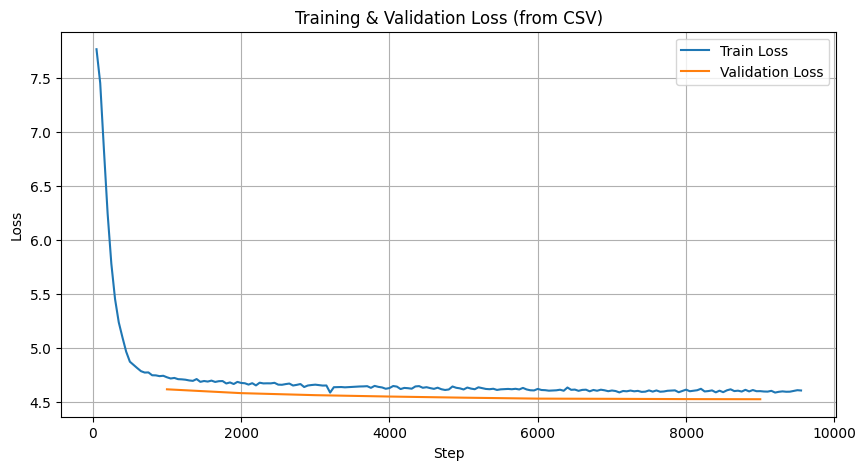

In [27]:
csv_path = "/content/drive/MyDrive/prophetnet_training_logs.csv"
logs = pd.read_csv(csv_path)

train_logs = logs[logs["loss"].notnull()]
eval_logs  = logs[logs["eval_loss"].notnull()]

plt.figure(figsize = (10, 5))
plt.plot(train_logs["step"], train_logs["loss"], label = "Train Loss")
plt.plot(eval_logs["step"],  eval_logs["eval_loss"], label = "Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (from CSV)")
plt.legend()
plt.grid()
plt.show()

In [29]:
# Displaying 10 random test samples with generated summaries

print("\n=== 10 Random Test Summaries ===\n")
for idx in random.sample(range(len(test_dataset)), 10):
    art = test_dataset[idx]["document"]
    inp = tokenizer(art, return_tensors = "pt", truncation = True, padding = True).to(model.device)
    gen_ids = model.generate(**inp, max_length = 64, num_beams = 5, length_penalty = 1.2, no_repeat_ngram_size = 3)
    summary = tokenizer.decode(gen_ids[0], skip_special_tokens = True)
    print(f"--- ARTICLE #{idx} ---\n{art}\n")
    print(f"--- GENERATED SUMMARY ---\n{summary}\n")
    print(f"--- REFERENCE SUMMARY ---\n{test_dataset[idx]['summary']}\n")
    print("="*80, "\n")


=== 10 Random Test Summaries ===

--- ARTICLE #6912 ---
ZTE Corp obtained and illegally shipped US-made equipment to Iran in violation of US sanctions, the Justice Department said.
It also sent goods to North Korea without the correct export licences.
The US said ZTE lied to authorities and its own lawyer about the violations.
It must now pay a $892m (Â£740m) penalty as well as $300m which will be suspended for seven years depending on the firm meeting certain conditions.
ZTE says it acknowledges it has made mistakes, and is working towards improving its procedures.
The US said that the highest levels of management at ZTE approved the scheme which involved the shipment of $32m worth of US-made goods to Iran between 2010 and 2016.
The equipment included routers, microprocessors and servers controlled under export regulations for "security, encryption... and/or anti-terrorism reasons".
ZTE also made 283 shipments of mobile phones to North Korea despite knowing this contravened rules aro